In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name="/content/drive/MyDrive/fire_dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
#import modules
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import os
from pathlib import Path
from tqdm.auto import tqdm
import random

#set random seed for reproducibility
seed = 42

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#define custom data subset
class MySubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]

        #if a transform argument is provided, apply the transformaiton to the subset
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
#define function for training and evaluating each epoch
def train_per_epoch(model, train_dataloader, test_dataloader, loss_fn, optimizer):

    model.train()
    train_loss, train_acc = 0, 0

    #loop through data loader data batches

    for batch, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), torch.unsqueeze(y, dim=1).float().to(device)

        #make prediction
        y_logits = model(X)
        y_pred = torch.round(torch.sigmoid(y_logits))

        #calculate and accumulate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        #calculate and accumulate accuracy
        acc = (y_pred == y).sum().item()/len(y)
        train_acc += acc

        #update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Calculate the average loss and average acc by batch (in one epoch)
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    ### Testing Loop
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (X, y) in enumerate(test_dataloader):

            X, y = X.to(device), torch.unsqueeze(y, dim=1).float().to(device)

            test_logits = model(X)
            test_pred = torch.round(torch.sigmoid(test_logits))

            loss = loss_fn(test_logits, y)
            test_loss += loss.item()

            #calculate and accumulate accuracy
            acc = (test_pred == y).sum().item()/len(y)
            test_acc += acc

    #Calculate the average loss and average acc by batch (in one epoch)
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)
    return train_loss, train_acc, test_loss, test_acc

In [ ]:
#setup ModelCheckpoint
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [ ]:
#define train function
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, best_model_path):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    #setup early stopping and model checkpoint
    early_stop_threshold = 10
    best_loss = float("inf")
    best_epoch = -1

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, test_loss, test_acc = train_per_epoch(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer)

        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        #update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        #EarlyStopping and ModelCheckpoint
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            checkpoint(model, best_model_path)
        elif epoch - best_epoch > early_stop_threshold:
            break  # terminate the training loop

    print(f"Epoch with best loss: Epoch {best_epoch+1} at {best_loss:.4f}")

    return results

In [ ]:
#get a set of pretrained model weights
weights = models.MobileNet_V3_Small_Weights.DEFAULT
weights

MobileNet_V3_Small_Weights.IMAGENET1K_V1

In [ ]:
#get the data transformations used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
root_dir = "fire_dataset"

fire_dataset_tl = ImageFolder(root_dir)

In [ ]:
#the classes are the names of the files in the root folder
class_names = fire_dataset_tl.classes
class_names

#class names as a dict
class_dict = fire_dataset_tl.class_to_idx
class_dict

{'0_non_fire_images': 0, '1_fire_images': 1}

In [ ]:
#random_split the dataset in training, validation and testing
train_dataset_tl, valid_dataset_tl, test_dataset_tl = random_split(fire_dataset_tl, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(seed))

In [ ]:
#apply data transformation to the training and validation dataset
train_dataset_tl = MySubset(train_dataset_tl, transform=auto_transforms)
valid_dataset_tl = MySubset(valid_dataset_tl, transform=auto_transforms)

In [ ]:
#load the data using DataLoader
batch_size = 32
train_loader_tl = DataLoader(train_dataset_tl, batch_size=batch_size, shuffle=True)
valid_loader_tl = DataLoader(valid_dataset_tl, batch_size=batch_size, shuffle=False)

In [ ]:
#load the weights into the model
model_tl = models.mobilenet_v3_small(weights=weights).to(device)
model_tl

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 31.4MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
for param in model_tl.features.parameters():
    param.requires_grad = False

In [ ]:
#set the manual seeds
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


class network(nn.Module):

    def __init__(self):

        super().__init__()
        self.linear1=nn.Linear(576, 1024, bias=True)
        self.hardwish=nn.Hardswish()
        self.dropout=nn.Dropout(p=0.2, inplace=True)
        self.linear2=nn.Linear(1024, 1, bias=True).to(device)

    def forward(self, x):
        x = self.linear1(x)
        x = self.hardwish(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x

model_tl.classifier = network()

#redefine classifier layer
# model_tl.classifier = torch.nn.Sequential(
#     nn.Linear(in_features=576, out_features=1024, bias=True),
#     nn.Hardswish(),
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(in_features=1024, out_features=1, bias=True)).to(device)

In [ ]:
#set random seeds
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

NUM_EPOCHS = 10

#loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_tl.parameters(), lr=0.0001)

#train model_tl
model_tl_results = train(model=model_tl, train_dataloader=train_loader_tl, test_dataloader=valid_loader_tl, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, best_model_path = "best_model_tl.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5832 | train_acc: 0.6515 | test_loss: 0.4979 | test_acc: 0.7396
Epoch: 2 | train_loss: 0.4028 | train_acc: 0.8323 | test_loss: 0.3751 | test_acc: 0.9010
Epoch: 3 | train_loss: 0.2934 | train_acc: 0.9237 | test_loss: 0.2739 | test_acc: 0.9427
Epoch: 4 | train_loss: 0.2135 | train_acc: 0.9537 | test_loss: 0.2054 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.1826 | train_acc: 0.9587 | test_loss: 0.1617 | test_acc: 0.9635
Epoch: 6 | train_loss: 0.1573 | train_acc: 0.9613 | test_loss: 0.1335 | test_acc: 0.9635
Epoch: 7 | train_loss: 0.1439 | train_acc: 0.9587 | test_loss: 0.1217 | test_acc: 0.9531
Epoch: 8 | train_loss: 0.1265 | train_acc: 0.9611 | test_loss: 0.1044 | test_acc: 0.9844
Epoch: 9 | train_loss: 0.1096 | train_acc: 0.9675 | test_loss: 0.0972 | test_acc: 0.9583
Epoch: 10 | train_loss: 0.1043 | train_acc: 0.9723 | test_loss: 0.0858 | test_acc: 0.9792
Epoch with best loss: Epoch 10 at 0.0858


In [ ]:
resume(model_tl, "best_model_tl.pth")

In [ ]:
def evaluation(model, test_dataloader, loss_fn):

    ###Testing Loop
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (X, y) in enumerate(test_dataloader):

            X, y = X.to(device), torch.unsqueeze(y, dim=1).float().to(device)

            test_logits = model(X)
            test_pred = torch.round(torch.sigmoid(test_logits))

            loss = loss_fn(test_logits, y)
            test_loss += loss.item()

            #calculate and accumulate accuracy
            acc = (test_pred == y).sum().item()/len(y)
            test_acc += acc

    #calculate the average loss and average acc by batch (in one epoch)
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)
    print(f"Model achieved an accuracy of {test_acc*100: .4f}% and an average loss of {test_loss: .4f}")
    return test_loss, test_acc

In [ ]:
# test_dataset_transformed = MySubset(test_dataset, transform=data_transform)
test_dataset_tl_transformed = MySubset(test_dataset_tl, transform=auto_transforms)

# test_loader = DataLoader(test_dataset_transformed, shuffle=False)

test_loader_tl = DataLoader(test_dataset_tl_transformed, shuffle=False)

In [ ]:
torch.manual_seed(seed)
#predict using model_tl
model_tl_loss, model_tl_acc = evaluation(model_tl, test_loader_tl, loss_fn)

Model achieved an accuracy of  97.6048% and an average loss of  0.1162


In [ ]:
#define function to predict custom images
def pred_and_plot_image(model, image_path, transform, device: torch.device=device):

    img = Image.open(image_path)

    image_transform = transform

    model.to(device)
    model.eval()
    with torch.inference_mode():

        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

        target_image_pred_probs = torch.sigmoid(target_image_pred)
        target_image_pred_label = torch.round(target_image_pred_probs)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {target_image_pred_label.cpu().numpy()[0][0]} | Prob: {target_image_pred_probs.cpu().numpy()[0][0]: .3f}")
    plt.axis(False);

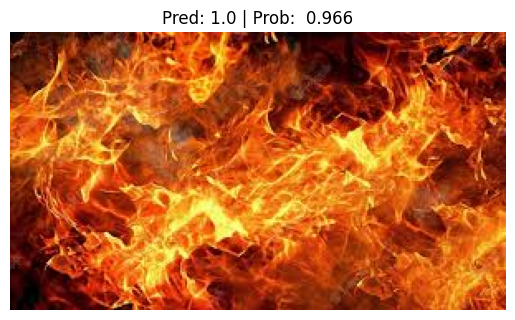

In [ ]:
#predict fire image
pred_and_plot_image(model_tl, "fire.jpeg", auto_transforms, device)

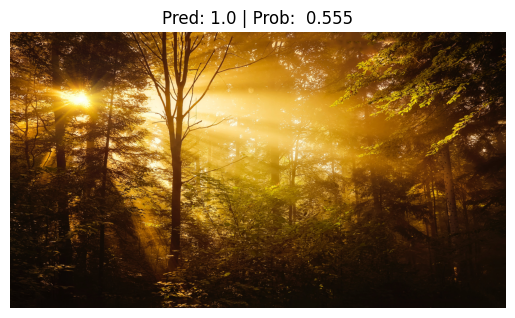

In [ ]:
#predict non-fire image
pred_and_plot_image(model_tl, "non_fire_image.jpg", auto_transforms, device)